データを読み込みました。形状: (733, 55)
カラム: ['InspectionDateAndId', 'PublicId', 'EyeSide', 'MoCALabel', 'MoCA', 'Age', 'LatencyMean', 'LatencyMax', 'LatencyStd', 'SaccadeWidthMaxMin', 'VelocityMaxMean', 'VelocityMaxMax', 'LatencyMeanIsError0', 'LatencyMaxIsError0', 'LatencyStdIsError0', 'LatencyMaxIsError1', 'LatencyStdIsError1', 'ResponseTimeMeanIsError0', 'ResponseTimeMaxIsError0', 'ResponseTimeStdIsError0', 'SaccadeCountMeanIsError0', 'SaccadeCountStdIsError0', 'VelocityMaxMeanIsError0', 'VelocityMaxMaxIsError0', 'VelocityMaxStdIsError0', 'VelocityMaxMeanIsError1', 'GainMinIsError0', 'LatencyMeanDistanceFlg0', 'LatencyMaxDistanceFlg0', 'LatencyMeanDistanceFlg1', 'LatencyMinDistanceFlg1', 'LatencyMaxDistanceFlg1', 'LatencyStdDistanceFlg1', 'LatencyMeanDistanceFlg2', 'LatencyMaxDistanceFlg2', 'LatencyStdDistanceFlg2', 'ResponseTimeMeanDistanceFlg1', 'ResponseTimeMeanDistanceFlg2', 'ResponseTimeMaxDistanceFlg2', 'ResponseTimeStdDistanceFlg2', 'SaccadeCountStdDistanceFlg1', 'SaccadeCountMeanDistance

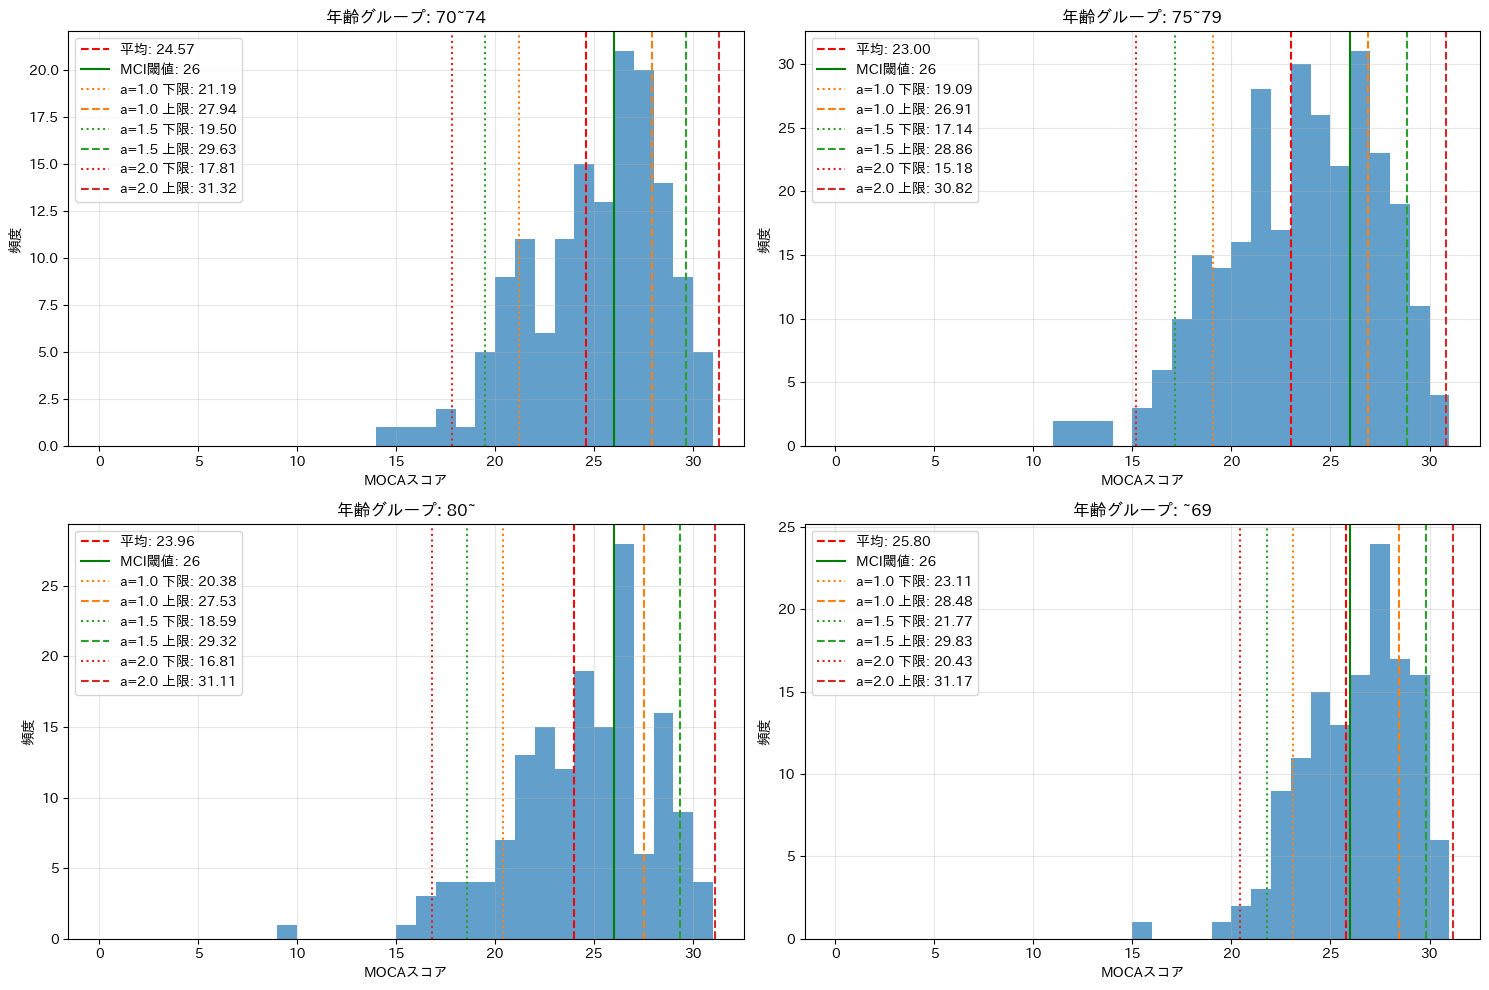

<Figure size 1200x800 with 0 Axes>

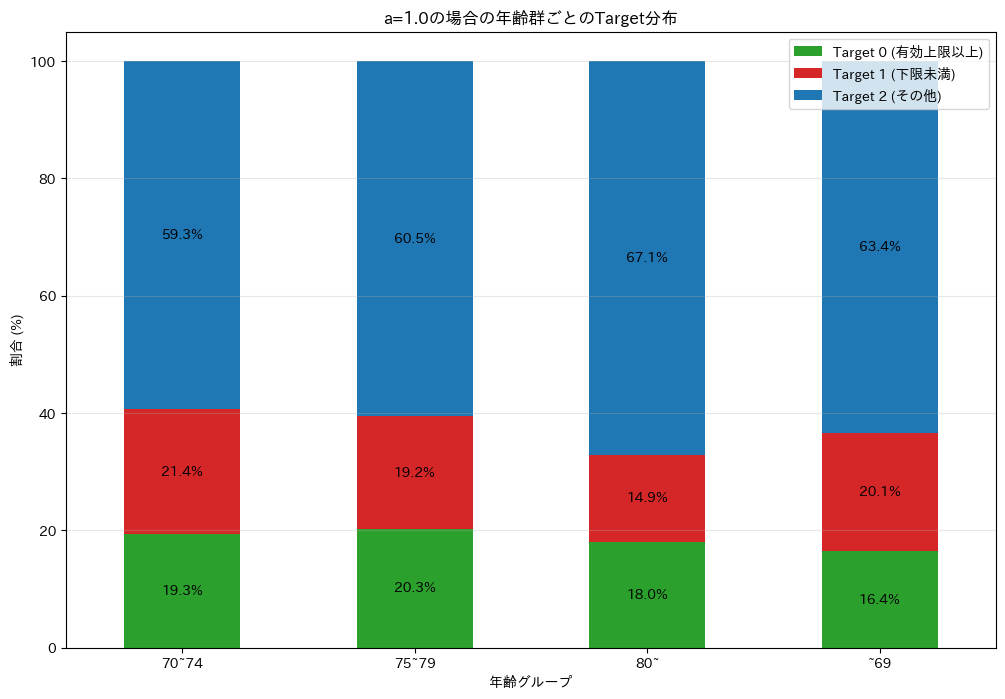

<Figure size 1200x800 with 0 Axes>

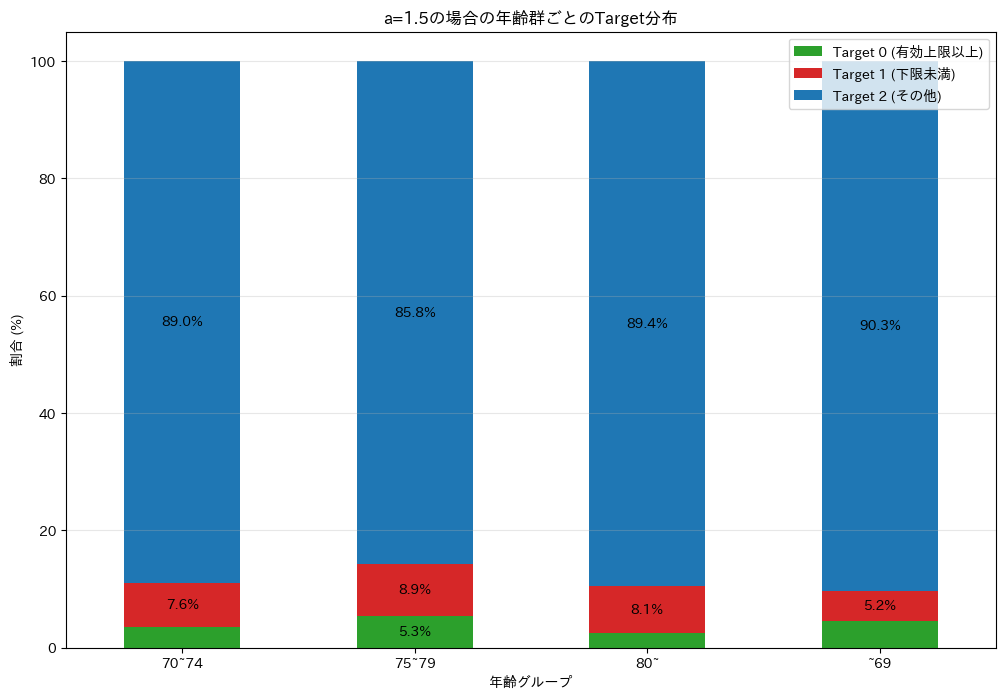

<Figure size 1200x800 with 0 Axes>

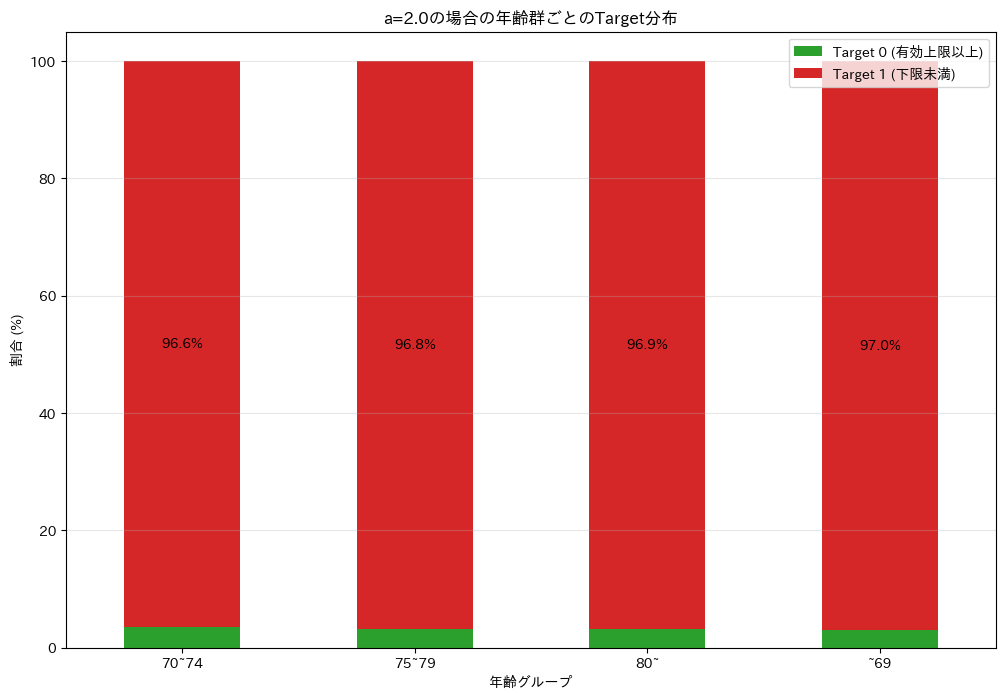


結果を保存しました: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\shizuoka2023_0404_a1.0.csv

結果を保存しました: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\shizuoka2023_0404_a1.5.csv

結果を保存しました: G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result\shizuoka2023_0404_a2.0.csv


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import japanize_matplotlib

#------------------------------------------------------------
# ファイルパスの設定 - ここを変更してください
#------------------------------------------------------------
# データファイルのパス
path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/data"
file_name = "shizuoka2023_0404_50features.csv"  # この部分を分析したいファイル名に変更
file_path = f"{path}/{file_name}"

# 結果の出力先
output_path = "G:/共有ドライブ/GAP_長寿研/user/iwamoto/視線の動きの俊敏さ/result"
#------------------------------------------------------------

# 年齢グループ分類関数
def assign_age_group(age):
    """年齢を年齢グループに分類"""
    if age <= 69:
        return "~69"
    elif 70 <= age <= 74:
        return "70~74"
    elif 75 <= age <= 79:
        return "75~79"
    else:
        return "80~"

# データの読み込み関数
def load_data(file_path):
    """MOCAスコアデータを読み込む（CSVまたはタブ区切り）"""
    try:
        # ファイル拡張子の確認
        _, file_extension = os.path.splitext(file_path)
        
        if file_extension.lower() == '.csv':
            # CSVファイルとして読み込み試行
            try:
                df = pd.read_csv(file_path)
            except:
                # カンマ区切りで失敗した場合、セミコロン区切りで試行
                df = pd.read_csv(file_path, sep=';')
        else:
            # タブ区切りファイルとして読み込み
            df = pd.read_csv(file_path, sep='\t')
        
        print(f"データを読み込みました。形状: {df.shape}")
        print(f"カラム: {df.columns.tolist()}")
        
        # カラム名の確認
        # MoCAとAgeのカラムを探す（大文字小文字の違いを考慮）
        moca_column = None
        age_column = None
        
        for col in df.columns:
            if col.lower() in ['moca', 'モカ', 'mocaスコア']:
                moca_column = col
            elif col.lower() in ['age', '年齢']:
                age_column = col
        
        if moca_column and age_column:
            # 正しいカラム名がある場合、標準名に変更
            df = df.rename(columns={moca_column: 'MoCA', age_column: 'Age'})
        elif len(df.columns) == 2:
            # カラムが2つしかない場合、MOCAとAgeと仮定
            df.columns = ['MoCA', 'Age']
        else:
            print("警告: MOCAスコアと年齢のカラムを特定できませんでした。データ形式を確認してください。")
            return None
        
        # データ型の確認と変換
        df['MoCA'] = pd.to_numeric(df['MoCA'], errors='coerce')
        df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
        
        # 無効な値を持つ行を削除
        original_count = len(df)
        df = df.dropna()
        if len(df) != original_count:
            print(f"警告: {original_count - len(df)}行の無効なデータを削除しました。")
        
        return df
        
    except Exception as e:
        print(f"データ読み込みエラー: {e}")
        import traceback
        traceback.print_exc()
        return None

def create_target_columns(df, a_values=[1.0,1.5,2.0]):
    """
    指定されたa値に基づいてTarget列を作成する - 修正版
    
    条件:
    1. MOCAが (平均 - a×標準偏差) 未満ならTarget=1
    2. 上限閾値が26未満の場合は26を上限とする
    3. MOCAが (平均 + a×標準偏差) 以上または26以上ならTarget=0
    4. それ以外はTarget=2
    """
    # 年齢グループ列を追加
    df['AgeGroup'] = df['Age'].apply(assign_age_group)
    
    # 各年齢グループの統計量を計算
    group_stats = df.groupby('AgeGroup')['MoCA'].agg(['count', 'mean', 'std']).reset_index()
    print("\n年齢グループごとの統計量:")
    print(group_stats)
    
    # 各a値についてターゲット列を作成
    for a in a_values:
        # 各年齢グループの閾値を計算
        thresholds = {}
        for _, row in group_stats.iterrows():
            age_group = row['AgeGroup']
            mean_val = row['mean']
            std_val = row['std']
            lower_threshold = mean_val - a * std_val
            upper_threshold = mean_val + a * std_val
            
            # 上限閾値が26未満の場合は26を上限とする
            effective_upper = max(upper_threshold, 26.0)
            
            thresholds[age_group] = {
                'mean': mean_val,
                'std': std_val,
                'lower': lower_threshold,
                'upper': upper_threshold,
                'effective_upper': effective_upper  # 有効上限値を保存
            }
        
        print(f"\na={a}の場合の閾値:")
        for group, values in thresholds.items():
            print(f"{group}: 平均={values['mean']:.2f}, 標準偏差={values['std']:.2f}, "
                  f"下限={values['lower']:.2f}, 上限={values['upper']:.2f}, "
                  f"有効上限={values['effective_upper']:.2f}")
        
        # Target列の作成
        column_name = f'Target_a{a}'
        
        def assign_target(row):
            age_group = row['AgeGroup']
            moca_score = row['MoCA']
            lower_threshold = thresholds[age_group]['lower']
            upper_threshold = thresholds[age_group]['upper']
            
            # 条件1: MOCAが下限閾値未満ならTarget=1
            if moca_score < lower_threshold:
                return 1
            
            # 条件2: MOCAが上限閾値以上または26以上ならTarget=0
            if moca_score >= max(upper_threshold, 26.0):
                return 0
            
            # それ以外はTarget=2
            return 2
        
        df[column_name] = df.apply(assign_target, axis=1)
    
    return df, group_stats

def analyze_results(df, group_stats, a_values=[1.0,1.5,2.0]):
    """ターゲット列の分析結果を表示"""
    print("\n===== ターゲット列の分析 =====")
    
    # 全体での各Target値の割合
    for a in a_values:
        column_name = f'Target_a{a}'
        value_counts = df[column_name].value_counts(normalize=True) * 100
        print(f"\na={a}の場合のTarget分布:")
        for target_val in sorted(value_counts.index):
            percentage = value_counts[target_val]
            print(f"Target={target_val}: {percentage:.2f}%")
        
        # Target 0 と Target 1 の比率も表示
        target0_count = (df[column_name] == 0).sum()
        target1_count = (df[column_name] == 1).sum()
        print(f"Target 0 : Target 1 = {target0_count} : {target1_count}")
    
    # 年齢グループごとの各Target値の割合と人数の詳細
    print("\n年齢グループごとのTarget分布と詳細:")
    for a in a_values:
        column_name = f'Target_a{a}'
        print(f"\na={a}の場合:")
        
        # 集計用のデータフレームを作成
        target_summary = pd.DataFrame()
        
        for age_group in sorted(df['AgeGroup'].unique()):
            group_data = df[df['AgeGroup'] == age_group]
            
            # 閾値情報
            thresholds = group_stats[group_stats['AgeGroup'] == age_group].iloc[0]
            mean_val = thresholds['mean']
            std_val = thresholds['std']
            lower_threshold = mean_val - a * std_val
            upper_threshold = mean_val + a * std_val
            effective_upper = max(upper_threshold, 26.0)  # 有効上限値
            
            # Target値ごとの集計
            target_counts = group_data[column_name].value_counts()
            target0_count = target_counts.get(0, 0)
            target1_count = target_counts.get(1, 0)
            target2_count = target_counts.get(2, 0)
            
            # 下限未満の人数
            below_lower = len(group_data[group_data['MoCA'] < lower_threshold])
            
            # 上限以上の人数 (有効上限値を使用)
            above_upper = len(group_data[group_data['MoCA'] >= effective_upper])
            
            # 26以上の人数
            above_26 = len(group_data[group_data['MoCA'] >= 26])
            
            # 集計行を追加
            target_summary = pd.concat([target_summary, pd.DataFrame({
                '年齢グループ': [age_group],
                'サンプル数': [len(group_data)],
                'MOCA平均': [mean_val],
                'MOCA標準偏差': [std_val],
                '下限閾値': [f"{lower_threshold:.2f}"],
                '下限未満の人数': [below_lower],
                '上限閾値': [f"{upper_threshold:.2f}"],
                '有効上限閾値': [f"{effective_upper:.2f}"],
                '有効上限以上の人数': [above_upper],
                '26以上の人数': [above_26],
                'Target 0人数': [target0_count],
                'Target 1人数': [target1_count],
                'Target 2人数': [target2_count],
                'Target 0割合': [target0_count / len(group_data) * 100],
                'Target 1割合': [target1_count / len(group_data) * 100],
                'Target 2割合': [target2_count / len(group_data) * 100]
            })])
        
        # 集計結果を表示
        print(target_summary.set_index('年齢グループ'))
    
    # 年齢群ごとにより具体的な人数情報を表示
    for a in a_values:
        print(f"\na={a}の場合の詳細集計:")
        print("０：１")
        total_target0 = df[df[f'Target_a{a}'] == 0].shape[0]
        total_target1 = df[df[f'Target_a{a}'] == 1].shape[0]
        print(f"{total_target0}：{total_target1}")
        
        print("               下限　 人         上限　　　人       有効上限    人")
        for age_group in sorted(df['AgeGroup'].unique()):
            group_data = df[df['AgeGroup'] == age_group]
            
            # 閾値情報
            thresholds = group_stats[group_stats['AgeGroup'] == age_group].iloc[0]
            lower_threshold = thresholds['mean'] - a * thresholds['std']
            upper_threshold = thresholds['mean'] + a * thresholds['std']
            effective_upper = max(upper_threshold, 26.0)  # 有効上限値
            
            # 下限未満と上限以上の人数
            below_lower = len(group_data[group_data['MoCA'] < lower_threshold])
            above_upper = len(group_data[group_data['MoCA'] >= effective_upper])
            
            print(f"{age_group}            {lower_threshold:.2f}  {below_lower}         {upper_threshold:.2f}     {len(group_data[group_data['MoCA'] >= upper_threshold])}        {effective_upper:.2f}     {above_upper}")

def create_visualizations(df, group_stats, a_values=[1.0,1.5,2.0], output_dir=None):
    """分析結果を可視化"""
    # 年齢グループごとのMOCA分布
    plt.figure(figsize=(15, 10))
    for i, group in enumerate(sorted(df['AgeGroup'].unique())):
        group_data = df[df['AgeGroup'] == group]['MoCA']
        plt.subplot(2, 2, i+1)
        plt.hist(group_data, bins=range(0, 32), alpha=0.7)
        mean_val = group_data.mean()
        plt.axvline(x=mean_val, color='r', linestyle='--', 
                   label=f'平均: {mean_val:.2f}')
        plt.axvline(x=26, color='g', linestyle='-', label='MCI閾値: 26')
        
        # 各aの値に対する閾値を描画
        for a in a_values:
            stats_row = group_stats[group_stats['AgeGroup'] == group]
            if len(stats_row) > 0:
                std_val = stats_row['std'].values[0]
                lower = mean_val - a * std_val
                upper = mean_val + a * std_val
                effective_upper = max(upper, 26.0)  # 有効上限値
                
                plt.axvline(x=lower, color=f'C{a_values.index(a)+1}', linestyle=':', 
                           label=f'a={a} 下限: {lower:.2f}')
                plt.axvline(x=upper, color=f'C{a_values.index(a)+1}', linestyle='--', 
                           label=f'a={a} 上限: {upper:.2f}')
                
                # 有効上限が上限と異なる場合のみ表示
                if effective_upper != upper:
                    plt.axvline(x=effective_upper, color=f'C{a_values.index(a)+2}', linestyle='-.',
                               label=f'a={a} 有効上限: {effective_upper:.2f}')
        
        plt.title(f'年齢グループ: {group}')
        plt.xlabel('MOCAスコア')
        plt.ylabel('頻度')
        plt.legend()
        plt.grid(alpha=0.3)
    
    plt.tight_layout()
    
    if output_dir:
        plt.savefig(os.path.join(output_dir, 'moca_distribution_by_age_group.png'))
    plt.show()
    
    # 各aの値と年齢グループに対するTarget分布の棒グラフ
    for a in a_values:
        column_name = f'Target_a{a}'
        plt.figure(figsize=(12, 8))
        
        target_counts = pd.crosstab(df['AgeGroup'], df[column_name])
        target_percentages = pd.crosstab(df['AgeGroup'], df[column_name], normalize='index') * 100
        
        ax = target_percentages.plot(kind='bar', stacked=True, figsize=(12, 8), 
                                    color=['#2ca02c', '#d62728', '#1f77b4'])
        
        # ラベルとタイトルの設定
        ax.set_xlabel('年齢グループ')
        ax.set_ylabel('割合 (%)')
        ax.set_title(f'a={a}の場合の年齢群ごとのTarget分布')
        
        # 凡例の設定
        labels = ['Target 0 (有効上限以上)', 'Target 1 (下限未満)', 'Target 2 (その他)']
        ax.legend(labels, loc='upper right')
        
        # 各バーに値を追加
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            if height > 5:  # 5%以上の場合のみラベル表示
                ax.text(x+width/2, y+height/2, f'{height:.1f}%', 
                       ha='center', va='center')
        
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=0)
        
        if output_dir:
            plt.savefig(os.path.join(output_dir, f'target_distribution_a{a}.png'))
        plt.show()

# メイン関数
def main(file_path, output_dir=None):
    """MOCAスコアデータの分析メイン関数"""
    # データの読み込み
    df = load_data(file_path)
    if df is None:
        print("データの読み込みに失敗しました。")
        return
    
    # 基本的なデータの確認
    print("\nデータの最初の5行:")
    print(df.head())
    
    print("\nデータの基本統計量:")
    print(df.describe())
    
    # ターゲット列の作成（a=0.0, 0.5, 1.0の3つの値を使用）
    a_values = [1.0,1.5,2.0]
    df_with_targets, group_stats = create_target_columns(df, a_values)
    
    # 結果の分析
    analyze_results(df_with_targets, group_stats, a_values)
    
    # 可視化
    create_visualizations(df_with_targets, group_stats, a_values, output_dir)
    
    # 結果の保存
    if output_dir:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        # 各a値ごとにファイルを保存
        for a in a_values:
            output_file = os.path.join(output_dir, f'shizuoka2023_0404_a{a}.csv')
            df_with_targets.to_csv(output_file, index=False)
            print(f"\n結果を保存しました: {output_file}")
    
    return df_with_targets

# スクリプトとして実行される場合
if __name__ == "__main__":
    # ファイルの存在確認
    if not os.path.exists(file_path):
        print(f"エラー: ファイル '{file_path}' が見つかりません。")
        print(f"パスと名前を確認してください: {path} / {file_name}")
    else:
        # 分析実行
        result_df = main(file_path, output_path)